In [1]:
# importing the requisite lbraries and setting some parameters
import pandas as pd
import json
import requests
import numpy as np
import datetime
from datetime import date
from datetime import timedelta
import seaborn as sb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# set the Day_0 and Day_n and calculate the duration
day0 = "2020-02-01"
till_date = "2020-04-11"
tot_days = (date.today() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
print("Data available for " + str(tot_days) + " days.")

# setup the Figure rcParameters
sb.set_style("whitegrid")
SMALL_SIZE = 9
MEDIUM_SIZE = 9
BIGGER_SIZE = 9
plt.rc("font", size = SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize = SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize = SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["axes.labelweight"] = "bold"

Data available for 70 days.


In [2]:
# read the API
api_data_raw = requests.get("https://api.covid19india.org/raw_data.json").json()
head = list(api_data_raw["raw_data"][0].keys())

In [3]:
# making an empty dataframe to which the data from the API is added
temp = pd.DataFrame()
for i in api_data_raw["raw_data"]:
    api_data = pd.DataFrame([i.values()], columns = head)
    temp = temp.append(api_data, ignore_index = True)

# remove empty data rows
temp1 = list(temp.loc[0: len(api_data_raw["raw_data"]), "currentstatus"])
non_empty_temp = [i for i, item in enumerate(temp1) if item != ""]
api_data_raw = temp[0: len(non_empty_temp)]

In [4]:
# finding the printing the nationalities of corona virus patients in India
unique_nationalities = set(api_data_raw["nationality"].values.tolist())
unique_nationalities = list(unique_nationalities)
unique_nationalities.remove('')
print(unique_nationalities)

['India', 'United Kingdom', 'Thailand', 'United States of America', 'Phillipines', 'Myanmar', 'Malaysia', 'Indonesia', 'Italy', 'Canada', 'Tibet']


In [5]:
# manipulating the API data to get the date column in the correct format
temp_data = api_data_raw.copy()
temp1 = list(api_data_raw["dateannounced"])
DATE = [datetime.datetime.strptime(x, "%d/%m/%Y") for x in temp1]
temp_data["dateannounced"] = DATE
temp2 = pd.to_datetime(temp_data.dateannounced, format = "%Y-%m-%d")
temp_data["dateannounced"] = temp2.dt.strftime("%Y-%m-%d")

# set till_date as the last date available in api_data_raw
yesterday = date.today() - timedelta(days = 1)
date_yesterday = yesterday.strftime("%Y-%m-%d")
date_yesterday = till_date
data_temp = temp_data[(temp_data["dateannounced"] <= date_yesterday)]

In [6]:
# preparing the district data
data_district = data_temp.copy()
data_district = data_district.rename({"detecteddistrict": "District"}, axis = "columns")
data_district = data_district.rename({"dateannounced": "Date"}, axis = "columns")

data_district.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = 'int')
data_district.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = 'int')
data_district.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data_district[data_district["currentstatus"] == "Recovered"]
data_district.loc[list(temp.index), "Recovered"] = 1
temp = data_district[data_district["currentstatus"] == "Fatalities"]
data_district.loc[list(temp.index), "Fatalities"] = 1

temp_data = data_district.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data_district.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

districts = list(data_district.District.unique())
district_data = pd.DataFrame()

for j in range (0, len(districts)):
    st = data_district.query("District == " + '"' + districts[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([districts[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"District": name, "Date": pd.to_datetime(a, format = '%Y-%m-%d'), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    district_data = district_data.append(dd, ignore_index = True)

temp = pd.to_datetime(district_data.Date)
district_data["Date"] = temp.dt.strftime("%Y-%m-%d")

In [7]:
# preparing the state data
data = data_temp.copy()
data = data.rename({"detectedstate": "State"}, axis = "columns")
data = data.rename({"dateannounced": "Date"}, axis = "columns")

data.loc[:, "Confirmed"] = np.ones((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Recovered"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")
data.loc[:, "Fatalities"] = np.zeros((data_temp["dateannounced"].size), dtype = "int")

temp = data[data["currentstatus"] == "Recovered"]
data.loc[list(temp.index), "Recovered"] = 1
temp = data[data["currentstatus"] == "Fatalities"]
data.loc[list(temp.index), "Fatalities"] = 1

temp_data = data.copy()
temp2 = pd.to_datetime(temp_data.Date, format = "%Y-%m-%d")
data.loc[:, "Date"] = temp2.dt.strftime("%Y-%m-%d")

states = list(data.State.unique())
state_data = pd.DataFrame()

for j in range (0, len(states)):
    st = data.query("State == " +  '"' + states[j] + '"')
    date = list(st.Date.unique())
    a = list(pd.date_range(start = day0, end = till_date).date)
    dat1 = dict()
    dat2 = dict()
    for i in a:
        dt = st["Date"] == str(i)
        aa = st.loc[dt].Confirmed.sum()
        bb = st.loc[dt].Fatalities.sum()
        dat1[i] = aa
        dat2[i] = bb
    datc = np.array(list(dat1.values())).cumsum()
    datf = np.array(list(dat2.values())).cumsum()
    nam = pd.Series([states[j]])
    name = nam.repeat(len(a))
    days = np.arange(len(a))
    tempdata = {"State": name, "Date": pd.to_datetime(a, format = "%Y-%m-%d"), "Day": days, "ConfirmedCases": datc.T, "Fatalities": datf.T,}
    dd = pd.DataFrame.from_dict(tempdata)
    state_data = state_data.append(dd, ignore_index = True)

temp = pd.to_datetime(state_data.Date)
state_data["Date"] = temp.dt.strftime("%Y-%m-%d")

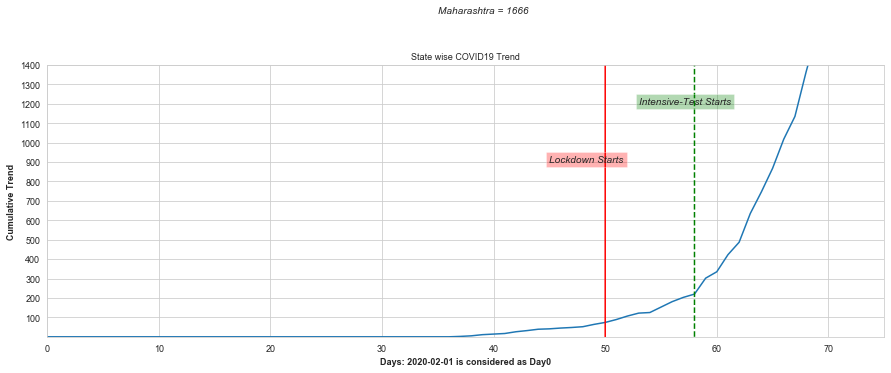

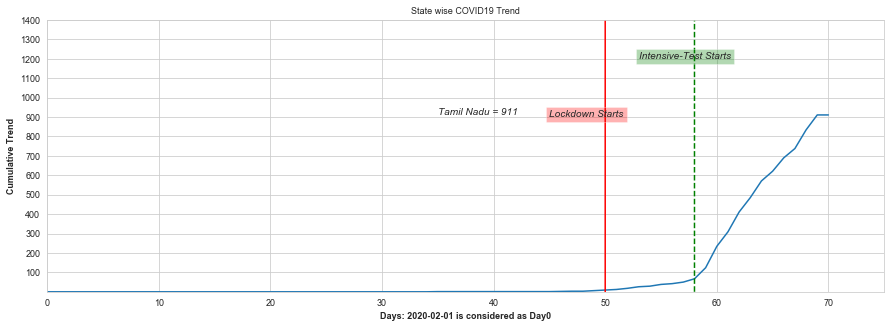

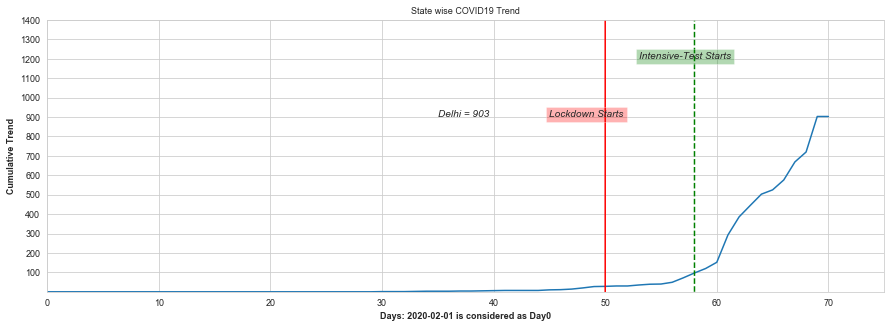

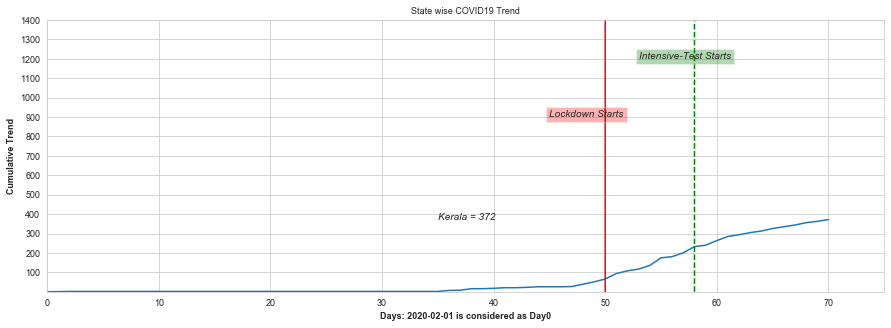

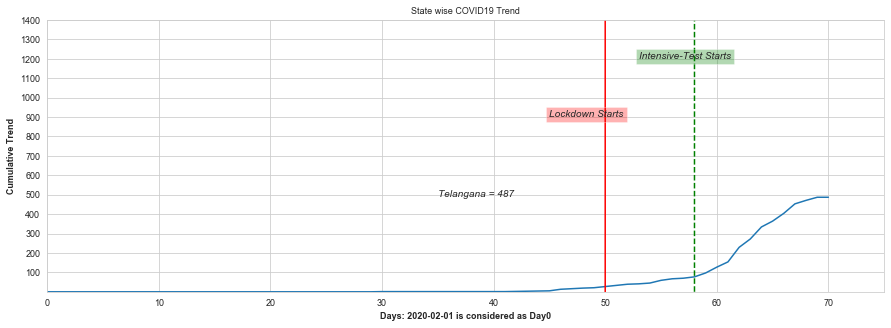

In [8]:
# provide the no. of highest infected (descending order)
no_states = 5
max_cases = 1500
xloc = 35

trains = state_data
states = list(trains.State.unique())
gb = pd.DataFrame(trains.groupby(["State"])["ConfirmedCases"].agg("sum"))
stsort = gb.sort_values(by = ["ConfirmedCases"], ascending = False)

for j in range (0, no_states):
    tt = trains.query("State == " + '"' + stsort.index[j] + '"')
    tss = tt.ConfirmedCases
    days = (tt.Day)
    plt.figure(figsize = (15, 5))
    plt.plot(days, (tss))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days + 5, 10))
    plt.xlim([0, tot_days + 5]);plt.ylim([0, 1200])
    plt.yticks(np.arange(100, max_cases, 100))
    plt.text(xloc, tss.iloc[-1], str(stsort.index[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("State wise COVID19 Trend")
    
    rangey = np.arange(0, max_cases)
    lockday = (datetime.datetime.strptime("2020-03-22", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    intense_day = (datetime.datetime.strptime("2020-03-30", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    plt.plot(np.ones((rangey.size)) * lockday,np.arange(0, max_cases), "r", label = "Lockdown_day")
    plt.text(lockday - 5, max_cases - 600, "Lockdown Starts", style = "italic", bbox = {"facecolor": "red", "alpha": 0.3, "pad": 3})
    plt.plot(np.ones((rangey.size)) * intense_day, np.arange(0, max_cases), "g--", label = "Intensive-Test Starts")
    plt.text(intense_day - 5, max_cases - 300, "Intensive-Test Starts", style = "italic", bbox = {"facecolor": "green", "alpha": 0.3, "pad": 3})

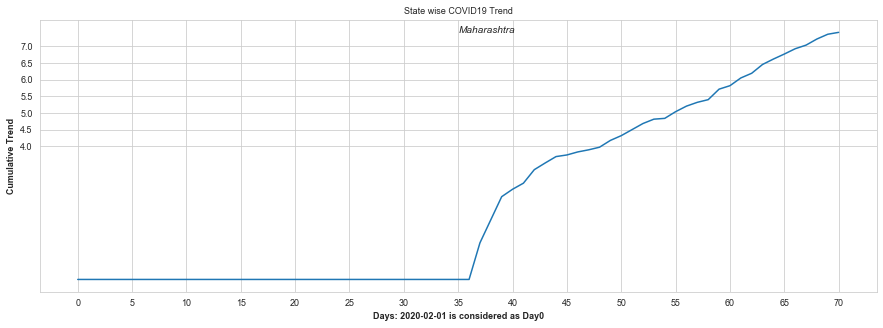

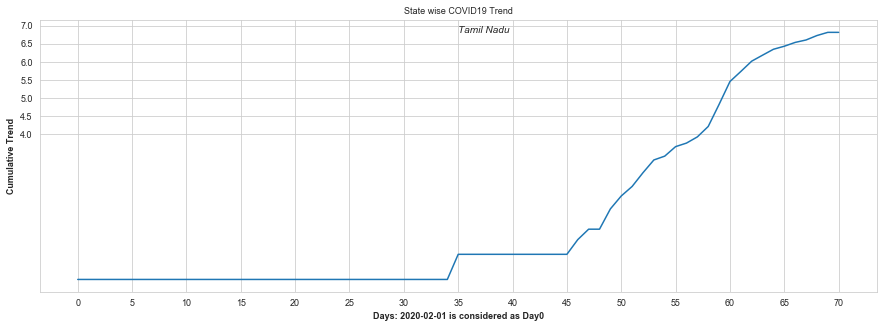

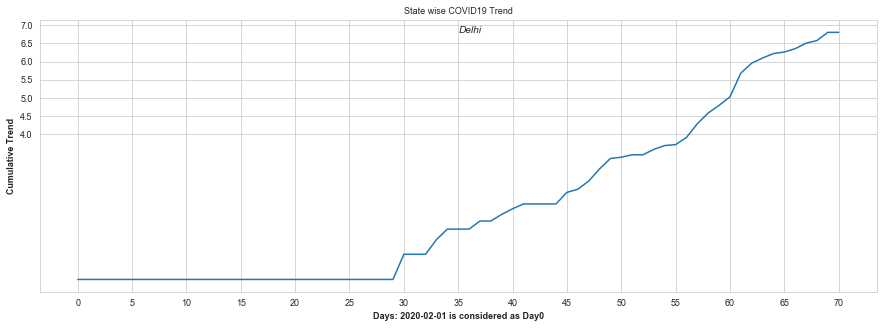

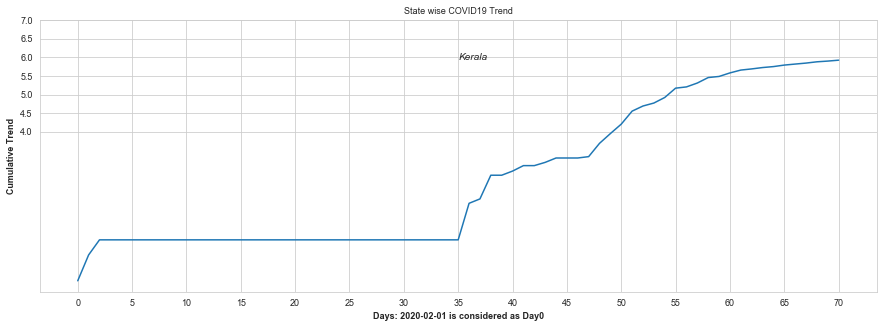

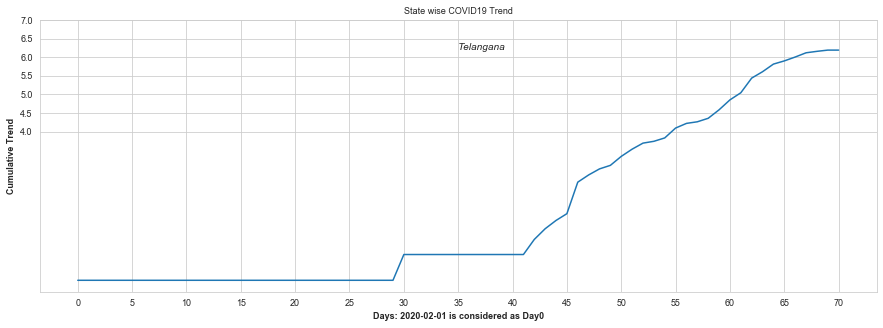

In [9]:
for j in range (0, no_states):
    tt = trains.query("State == " + '"' + stsort.index[j] + '"')
    tss = tt.ConfirmedCases
    days = (tt.Day)
    plt.figure(figsize = (15, 5))
    plt.plot(days, np.log(tss + 1))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(days[: : 5])
    plt.yticks(np.arange(4, 7.5, .5))
    plt.text(35, np.log(tss.max()), str(stsort.index[j]), style = "oblique")
    plt.title("State wise COVID19 Trend")

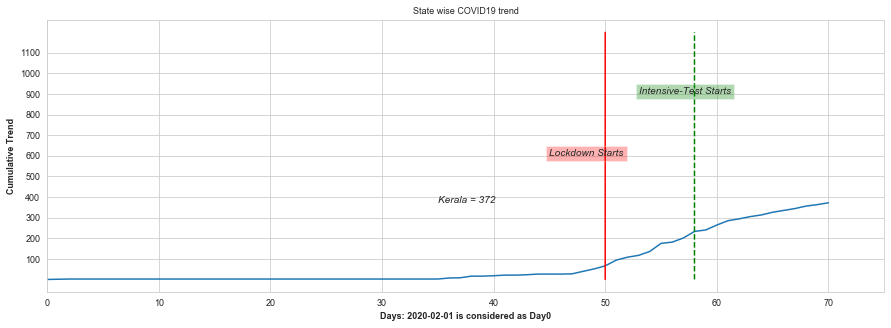

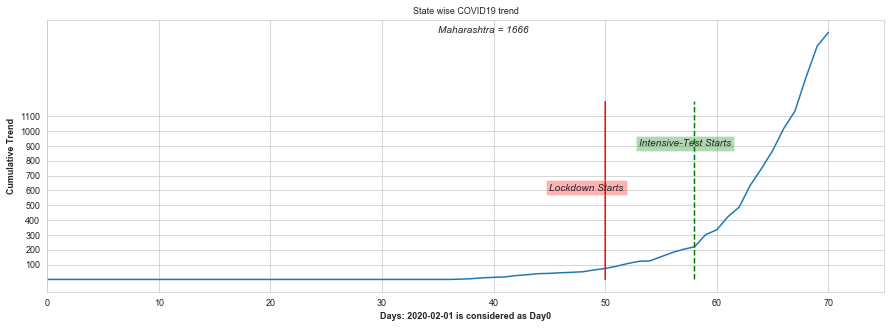

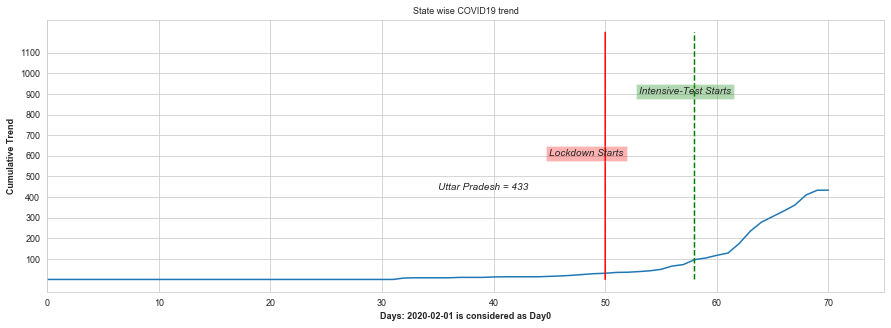

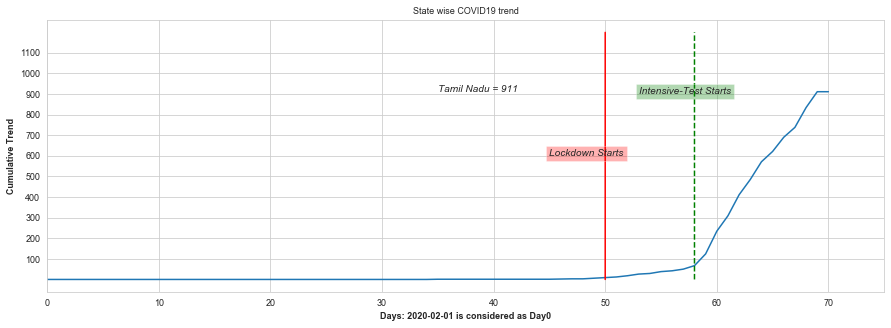

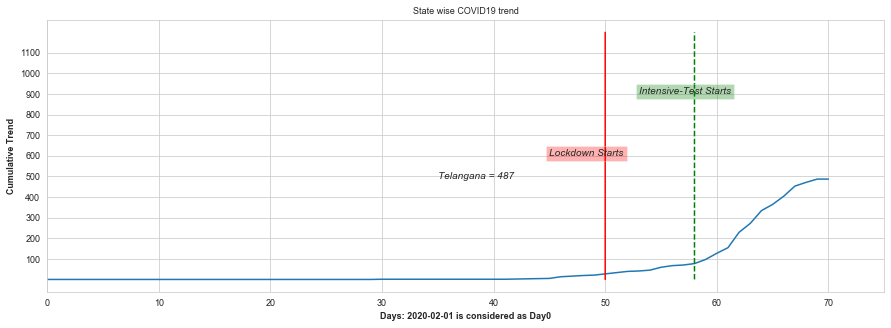

In [10]:
state_name = ["Kerala", "Maharashtra", "Uttar Pradesh", "Tamil Nadu", "Telangana"]
max_cases = 1200
xloc = 35

for j in range(0, len(state_name)):
    tt = trains.query("State == " + '"' + state_name[j] + '"')
    tss = tt.ConfirmedCases
    days = (tt.Day)
    plt.figure(figsize = (15, 5))
    plt.plot(days, tss)
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days + 5,10));plt.xlim([0, tot_days + 5])
    plt.yticks(np.arange(100, max_cases, 100))
    plt.text(xloc, tss.iloc[-1], str(state_name[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("State wise COVID19 trend")
    
    rangey = np.arange(0, max_cases)
    lockday = (datetime.datetime.strptime("2020-03-22", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    intense_day = (datetime.datetime.strptime("2020-03-30", "%Y-%m-%d").date() - datetime.datetime.strptime(day0, "%Y-%m-%d").date()).days
    plt.plot(np.ones((rangey.size)) * lockday,np.arange(0, max_cases), "r", label = "Lockdown_day")
    plt.text(lockday - 5, max_cases - 600, "Lockdown Starts", style = "italic", bbox = {"facecolor": "red", "alpha": 0.3, "pad": 3})
    plt.plot(np.ones((rangey.size)) * intense_day, np.arange(0, max_cases), "g--", label = "Intensive-Test Starts")
    plt.text(intense_day - 5, max_cases - 300, "Intensive-Test Starts", style = "italic", bbox = {"facecolor": "green", "alpha": 0.3, "pad": 3})

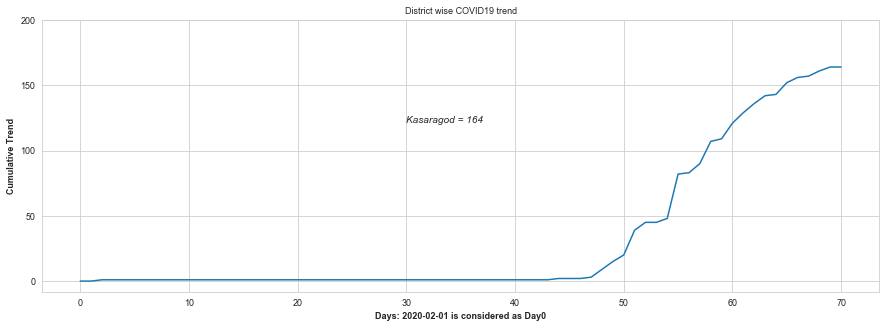

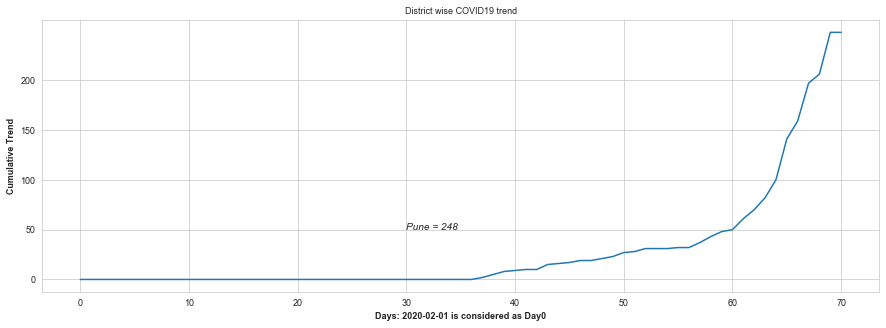

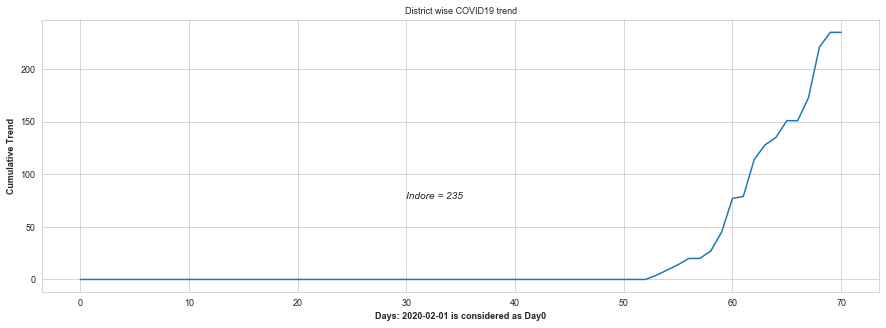

In [11]:
# provide the no. of highest infected (Descending order)
no_districts = 5
max_cases = 200
step = 50

traind = district_data
districts = list(traind.District.unique())
gb = pd.DataFrame(traind.groupby(["District"])["ConfirmedCases"].agg("sum"))
stsort = gb.sort_values(by = ["ConfirmedCases"], ascending = False)

for j in range (2, no_districts):
    tt = traind.query("District == " + '"' + stsort.index[j] + '"')
    tss = tt.ConfirmedCases
    days = (tt.Day)
    plt.figure(figsize = (15, 5))
    plt.plot(days,(tss))
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks(np.arange(0, tot_days + 5,10))
    plt.yticks(np.arange(0, max_cases + 1, step))
    plt.text(tot_days - 40, tss.iloc[tot_days - 10], str(stsort.index[j]) + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("District wise COVID19 trend")

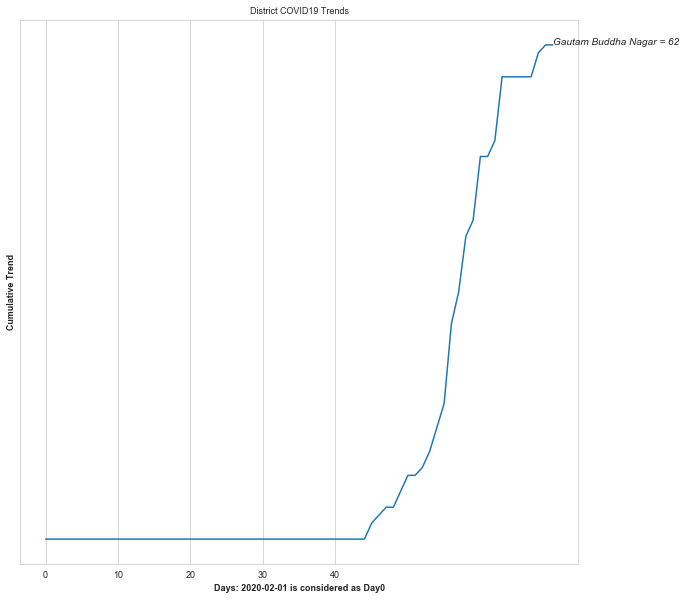

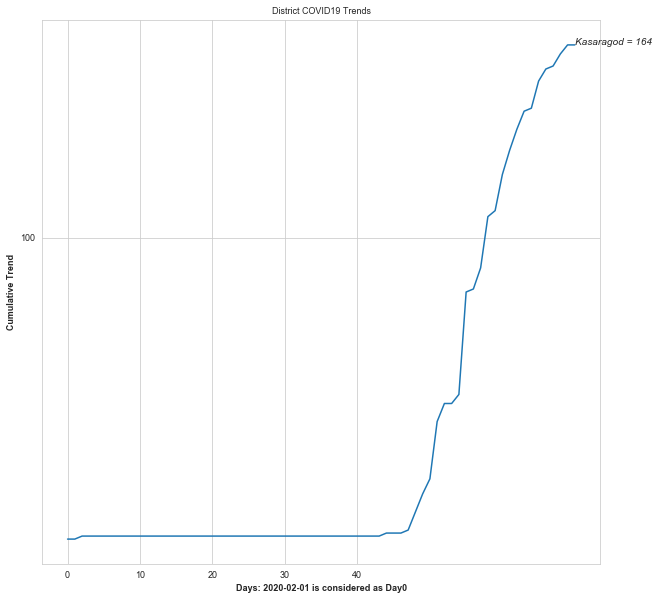

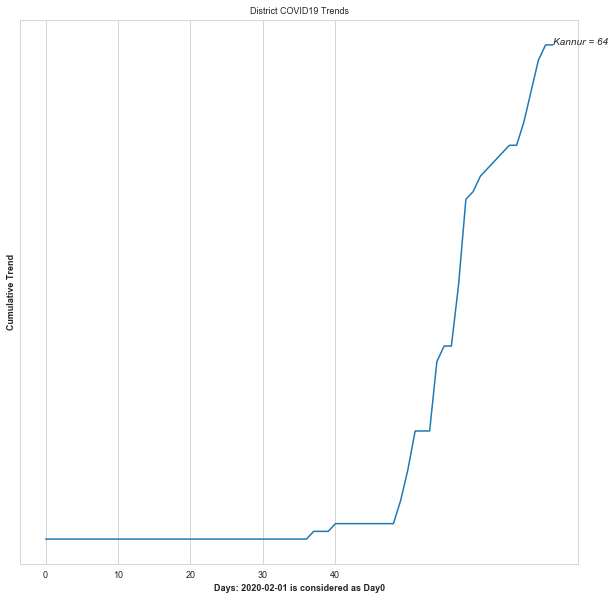

In [12]:
district_name = ["Gautam Buddha Nagar", "Kasaragod", "Kannur"]
max_cases = 200

for j in range(0, len(district_name)):
    tt = traind.query("District == " + '"' + district_name[j] + '"')
    tss = tt.ConfirmedCases
    days = (tt.Day)
    plt.figure(figsize = (10, 10))
    plt.plot(days,(tss)) 
    plt.xlabel("Days: " + str(day0) + " is considered as Day0")
    plt.ylabel("Cumulative Trend")
    plt.xticks([0, 10, 20, 30, 40])
    plt.yticks(np.arange(100, max_cases, 100)) 
    plt.text(tot_days, tss.iloc[-1], district_name[j] + " = " + str(tss.iloc[-1]), style = "oblique")
    plt.title("District COVID19 Trends")

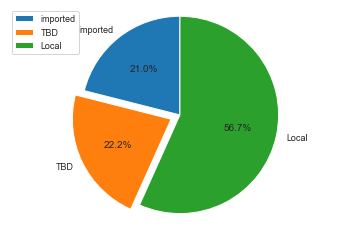

In [13]:
fd = data_temp.query('typeoftransmission == "Imported"')
imp = fd.loc[:, "typeoftransmission"].count()
fd = data_temp.query('typeoftransmission == "TBD"')
tbd = fd.loc[:, "typeoftransmission"].count()
fd = data_temp.query('typeoftransmission == "Local"')
local = fd.loc[:, "typeoftransmission"].count()
tt = np.array([imp,tbd,local])
labels = "imported", "TBD", "Local"
explode = (0, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(tt, explode = explode, labels = labels, autopct = "%1.1f%%", startangle = 90)
ax1.axis("equal")
plt.legend()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


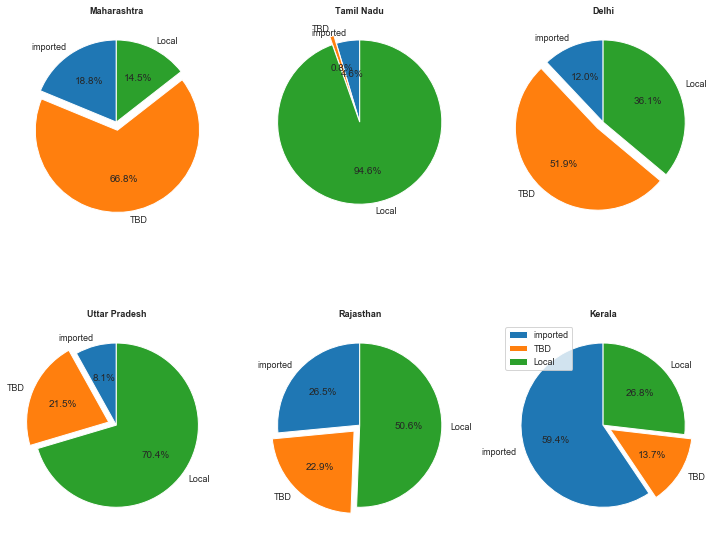

In [14]:
state = list(["Maharashtra", "Tamil Nadu", "Delhi", "Uttar Pradesh", "Rajasthan", "Kerala"])
labels = "imported", "TBD", "Local"
explode = (0, 0.1, 0)
count = 0

fig1, ax1 = plt.subplots(2,3, figsize = (10, 12), sharey = True)
for i in range(0, 2):
    for j in range(0, int(len(state) / 2), 1):
        fdd = data_temp.query('detectedstate == "' + str(state[count]) + '"')
        fd = fdd.query('typeoftransmission == "Imported"')
        imp = fd.loc[:, "typeoftransmission"].count()
        fd = fdd.query('typeoftransmission == "TBD"')
        tbd = fd.loc[:, "typeoftransmission"].count()
        fd = fdd.query('typeoftransmission == "Local"')
        local = fd.loc[:, "typeoftransmission"].count()
        tt = np.array([imp,tbd,local])
        patches, texts, autotexts = ax1[i,j].pie(tt, explode = explode, labels = labels, autopct = "%1.1f%%", startangle = 90)
        ax1[i,j].set_title(str(state[count]), fontweight = "bold")
        plt.tight_layout()
        plt.legend()
        count += 1

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


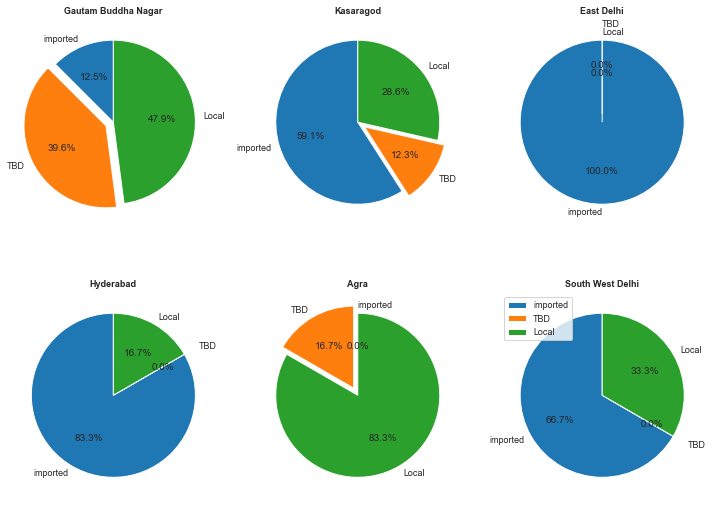

In [15]:
district = list(["Gautam Buddha Nagar", "Kasaragod", "East Delhi", "Hyderabad", "Agra", "South West Delhi", "Ghaziabad"])
labels = "imported", "TBD", "Local"
explode = (0, 0.1, 0)
count = 0

fig1, ax1 = plt.subplots(2, 3, figsize = (10, 10), sharey = True)
for i in range(0, 2):
    for j in range(0, int(len(district) / 2), 1):
        fdd = data_temp.query('detecteddistrict == "' + str(district[count]) + '"')
        fd = fdd.query('typeoftransmission == "Imported"')
        imp = fd.loc[:, "typeoftransmission"].count()
        fd = fdd.query('typeoftransmission == "TBD"')
        tbd = fd.loc[:, "typeoftransmission"].count()
        fd = fdd.query('typeoftransmission == "Local"')
        local = fd.loc[:, "typeoftransmission"].count()
        tt = np.array([imp, tbd, local])
        patches, texts, autotexts=ax1[i,j].pie(tt, explode = explode, labels = labels, autopct = "%1.1f%%", startangle = 90)
        ax1[i,j].set_title(str(district[count]), fontweight = "bold")
        plt.tight_layout()
        plt.legend()
        count += 1